# Parameter Scan

In [1]:
# Packages

import sys
sys.path.append('../datasets') 
import dataset_long as dsl

# Model
import numpy as np
import tellurium as te
# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Dataframe
import pandas as pd

#Estimation
import paramfitt_singlePatient as pf 
from scipy.optimize import minimize 
from collections import OrderedDict
from scipy.stats import qmc
from scipy.optimize import basinhopping
#Analyse Estimation
from scipy.stats import chi2
from scipy.stats import norm

#plots


#### linear spacing

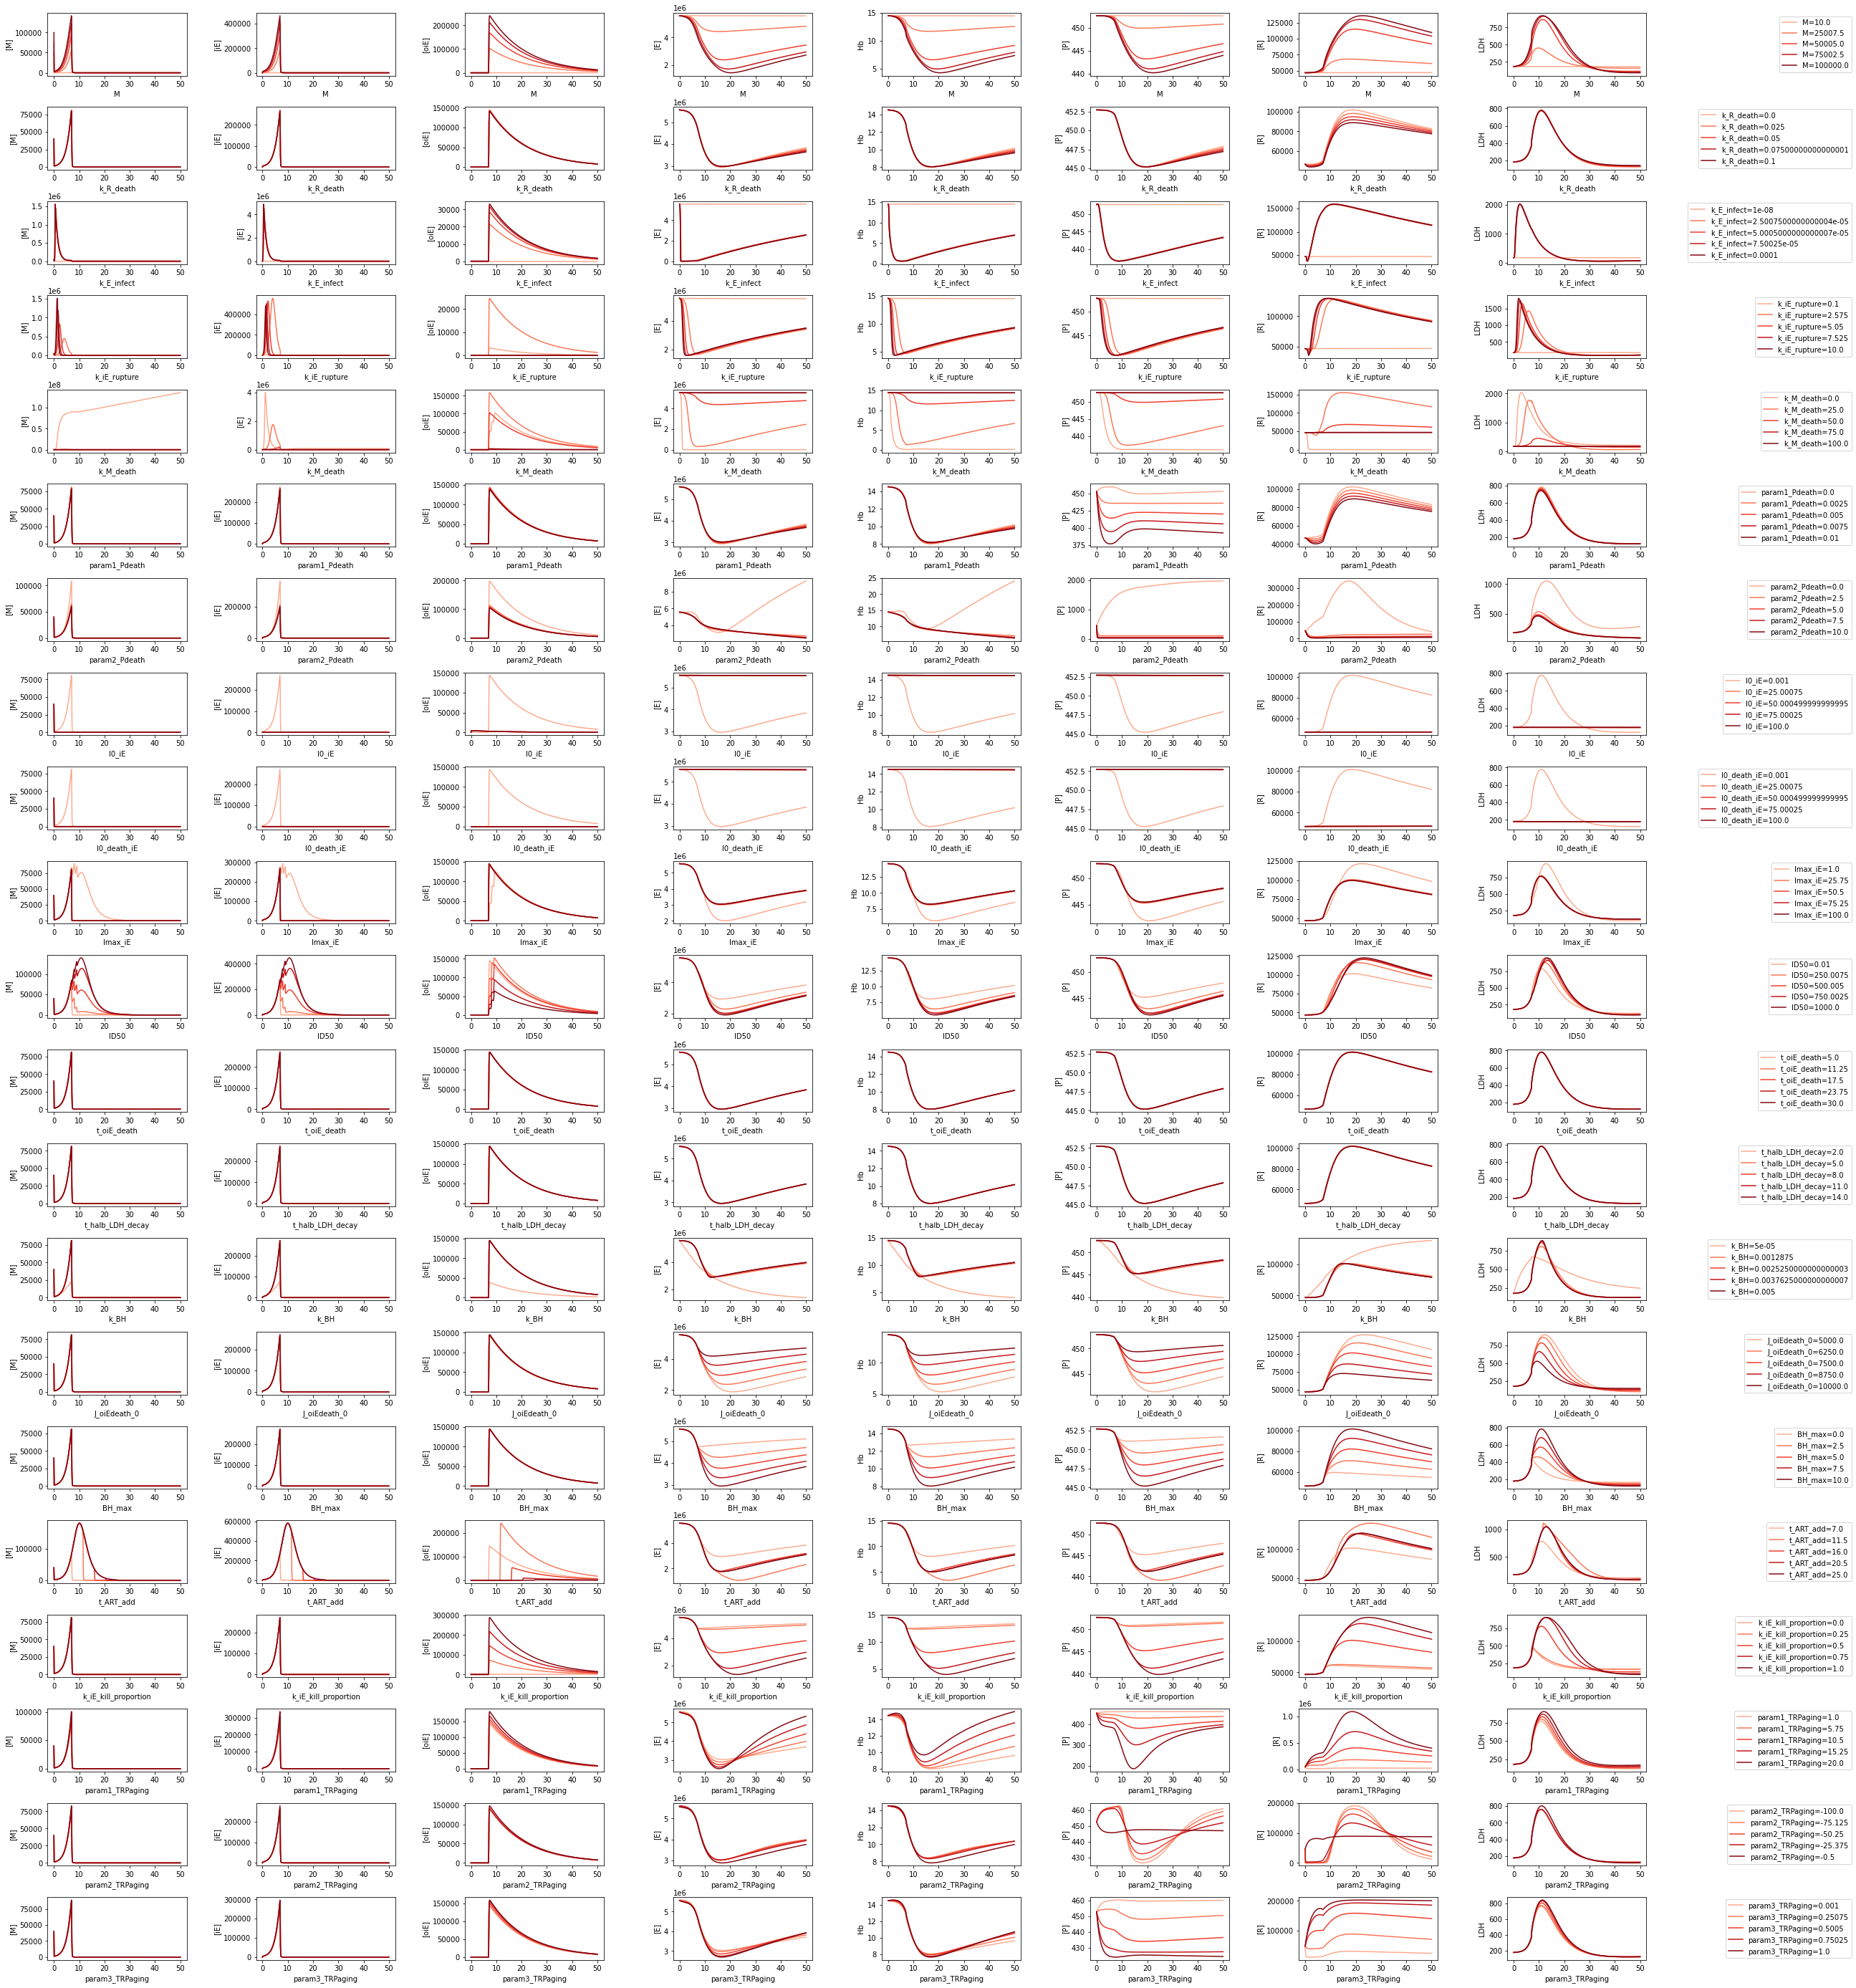

In [13]:

# Definition der Parameter-Boundaries
params_bounds = OrderedDict({
    'M': (1e1, 1e5),
    'k_R_death': (0, 1e-1),
    'k_E_infect': (1e-8, 1e-4),
    'k_iE_rupture': (1e-1, 10),
    'k_M_death': (0, 1e2) , 
    'param1_Pdeath': (0, 1e-2),
    'param2_Pdeath': (0, 10),
    'I0_iE': (1e-3, 1e2),
    'I0_death_iE': (1e-3, 1e2),
    'Imax_iE': (1, 100),
    #'hill': (2, 2.5),
    'ID50': (1e-2, 1000),
    't_oiE_death': (5, 30),
    't_halb_LDH_decay': (2, 14),
    'k_BH': (5e-5, 5e-3),
    'J_oiEdeath_0': (5000, 10000),
    'BH_max': (0, 10),
    't_ART_add': (7, 25),
    'k_iE_kill_proportion': (0,1),
    'param1_TRPaging':(1, 10),   #  maximal 11             = 3.53276388
    'param2_TRPaging': (1e-1, 100) ,                   #-5.99745537
    'param3_TRPaging': (1e-3, 1) #0.29658879'

})


# Anzahl der Werte pro Parameter
num_values_per_param = 5
species_to_analyze = ['[M]','[iE]','[oiE]','[E]','Hb','[P]','[R]','LDH']

# Erzeugung der Wertemengen für jeden Parameter
param_values = {}
for param, bounds in params_bounds.items():
    param_values[param] = np.linspace(bounds[0], bounds[1], num_values_per_param)

#print(param_values)

# Durchführung des Parameter-Scans und Erstellung der Plots
fig, axs = plt.subplots(len(params_bounds),len(species_to_analyze), figsize=(40, 50))
fig.subplots_adjust(hspace=0.5, wspace= 0.5)


# Farbübergang
cmap = plt.colormaps.get_cmap('Reds')
color_start = 0.3



OIE = te.loada('.././model/OIE_model.ant')


for i, (param, values) in enumerate(param_values.items()):

    for idx, value in enumerate(values):
        OIE.resetToOrigin()
        OIE.setValue(param, value)
        result = OIE.simulate(0, 50, 500, ['time']+species_to_analyze)
        #print(result)
        
        for j, specie in enumerate (species_to_analyze):

            # Plot der Ergebnisse
            axs[i][j].plot(result['time'], result[specie], label=f'{param}={value}',color=cmap(color_start + idx * (00.8 / num_values_per_param)))
            axs[i][j].set_xlabel(param)
            axs[i][j].set_ylabel(specie)
            if j == (len(species_to_analyze)-1):
                handles, labels = axs[i][j].get_legend_handles_labels()  # Legend Box outsides Subplots
                axs[i][j].legend(handles, labels, loc='center right', bbox_to_anchor=(2.5, 0.5),) #bbox (nach rechts-links, oben-unten, negativ yes)
#plt.tight_layout()
plt.show()



#### Param SCAN mit BH log spacing

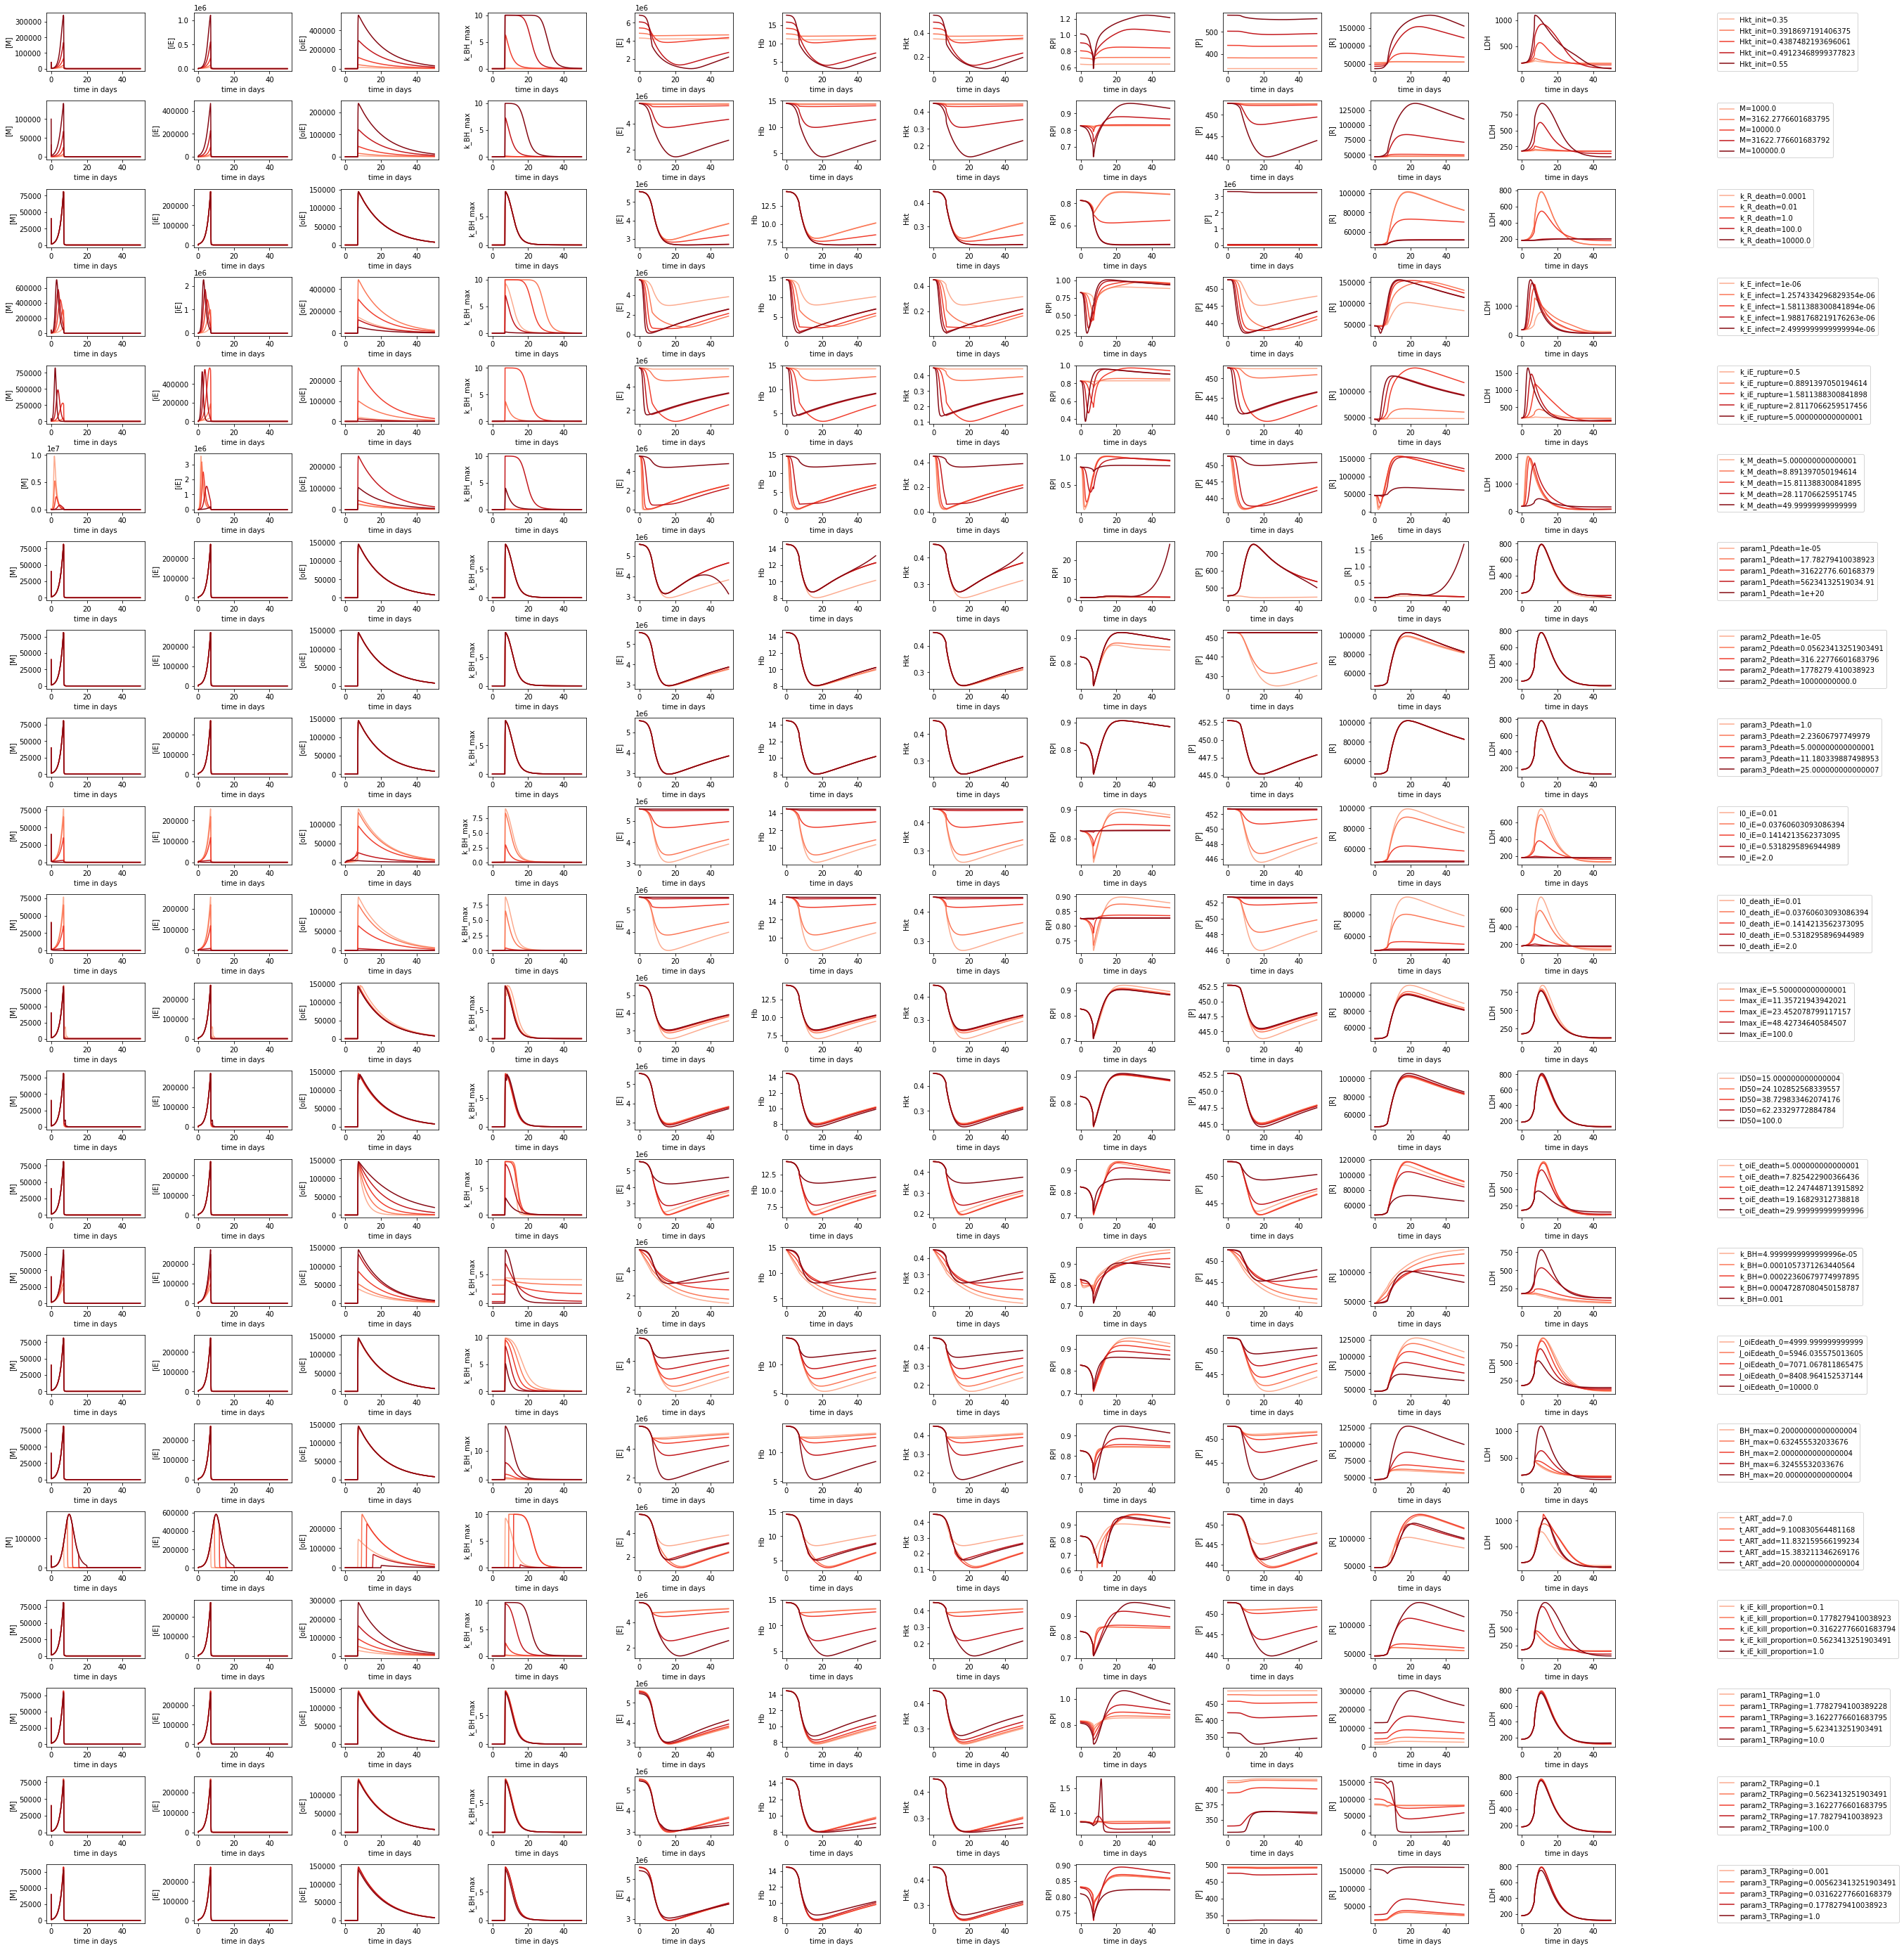

In [21]:
#Spezies
species_to_analyze = ['[M]','[iE]','[oiE]', 'k_BH_max','[E]','Hb','Hkt', 'RPI','[P]','[R]','LDH']

# Definition der Parameter-Boundaries
params_bounds = OrderedDict({
    'Hkt_init': (0.35, 0.55), 
    'M': (1e3, 1e5),                #
    'k_R_death': (1e-4, 1e4),         #rausnehmen aus fitting und auf 0 setzen im Model 
    'k_E_infect': (1e-6, 2.5e-6),   #
    'k_iE_rupture': (5e-1, 5),      #
    'k_M_death': (5, 50) ,          # höher als 3 sonst Reinfetion
    'param1_Pdeath': (1e-5, 1e20),  #sigmoid (1e-2,1e3),     # aus fitting rauslasen zu wenig einfluss    2e-5,0.01
    'param2_Pdeath': (1e-5, 1e10),  #sigmoid (1e-2,1e3) ,   #  aus fitting rauslasen zu wenig einfluss   0.01, 10
    'param3_Pdeath':  (1,25) , 
    'I0_iE': (1e-2, 2),             #
    'I0_death_iE': (1e-2, 2),       #
    'Imax_iE': (5.5, 1e2),     #5.5 war gut als unterer wenn viel niedriger Reinfektion, 1e1 oberre?
    #'hill': (2, 2.5),
    'ID50': (15, 1e2),             
    't_oiE_death': (5, 30),         #
    #'t_halb_LDH_decay': (2, 14),
    'k_BH': (5e-5, 1e-3),  #
    'J_oiEdeath_0': (5e3, 1e4),    #
    'BH_max': (2e-1, 20),
    't_ART_add': (7, 20),           #  
    'k_iE_kill_proportion': (0.1 ,1),
    'param1_TRPaging':(1, 10),   #  maximal 11             = 3.53276388
    'param2_TRPaging': (1e-1, 100) ,                   #-5.99745537
    'param3_TRPaging': (1e-3, 1) #0.29658879'
})


# Konvertiere bounds in logscale
params_bounds_log = pf.convert_bounds_to_logscale(params_bounds)

# Anzahl der Werte pro Parameter 
num_values_per_param = 5

# Erzeugung der Wertemengen für jeden Parameter
param_values = {}
for param, bounds in params_bounds_log.items():
    param_values[param] = np.linspace(bounds[0], bounds[1], num_values_per_param)

# Durchführung des Parameter-Scans und Erstellung der Plots
fig, axs = plt.subplots(len(params_bounds),len(species_to_analyze), figsize=(40, 50))
fig.subplots_adjust(hspace=0.5, wspace= 0.5)

# Farbübergang
cmap = plt.colormaps.get_cmap('Reds')
color_start = 0.3


for i, (param, values) in enumerate(param_values.items()):

    for idx, value in enumerate(values):
        model = te.loada('.././model/OIE_model.ant')
        #model.resetToOrigin()
        #model.setValue(param, 10**value)

        #"""
        model_str = model.getAntimony()        #lade Antimony string
        model_lines = model_str.split('\n')    #splitte in für jede Zeile
        new_model_lines = []

        for line in model_lines:         #gehe alle zeielen durch, ändere wnn parameter geändert werden soll, füge in neuen strig zu
            if line.startswith(f'{param}=') or line.startswith(f'{param} '):   # if line.startswith(param):
                line = f'{param}={10**value}'
            new_model_lines.append(line)
        new_model_str = '\n'.join(new_model_lines)    
        model = te.loada(new_model_str) 
        #"""

        result = model.simulate(0, 50, 500, ['time']+species_to_analyze)
        
        for j, specie in enumerate (species_to_analyze):

            # Plot der Ergebnisse
            axs[i][j].plot(result['time'], result[specie], label=f'{param}={10**value}', color=cmap(color_start + idx * (00.8 / num_values_per_param)))
            axs[i][j].set_xlabel('time in days')
            axs[i][j].set_ylabel(specie)
            if j == (len(species_to_analyze)-1):
                handles, labels = axs[i][j].get_legend_handles_labels()  # Legend Box outsides Subplots
                axs[i][j].legend(handles, labels, loc='center left', bbox_to_anchor=(2, 0.5),) #bbox (nach rechts-links, oben-unten, negativ yes)
plt.show()

#plt.savefig("plot.pdf")

#### Auswertung

- LDH und oiE Lebenszeiten aus Parameter Estimation raus (?)-> keine Variabilität in möglichen Bereich (medizin. Messwertebereich)
- k_R_death auf 0 setzen, hat einen EInfluss groß
- bei ID50 und ImaxiE aufpassen wegen Reinfektion




### ParamScan ohnE BH in log space

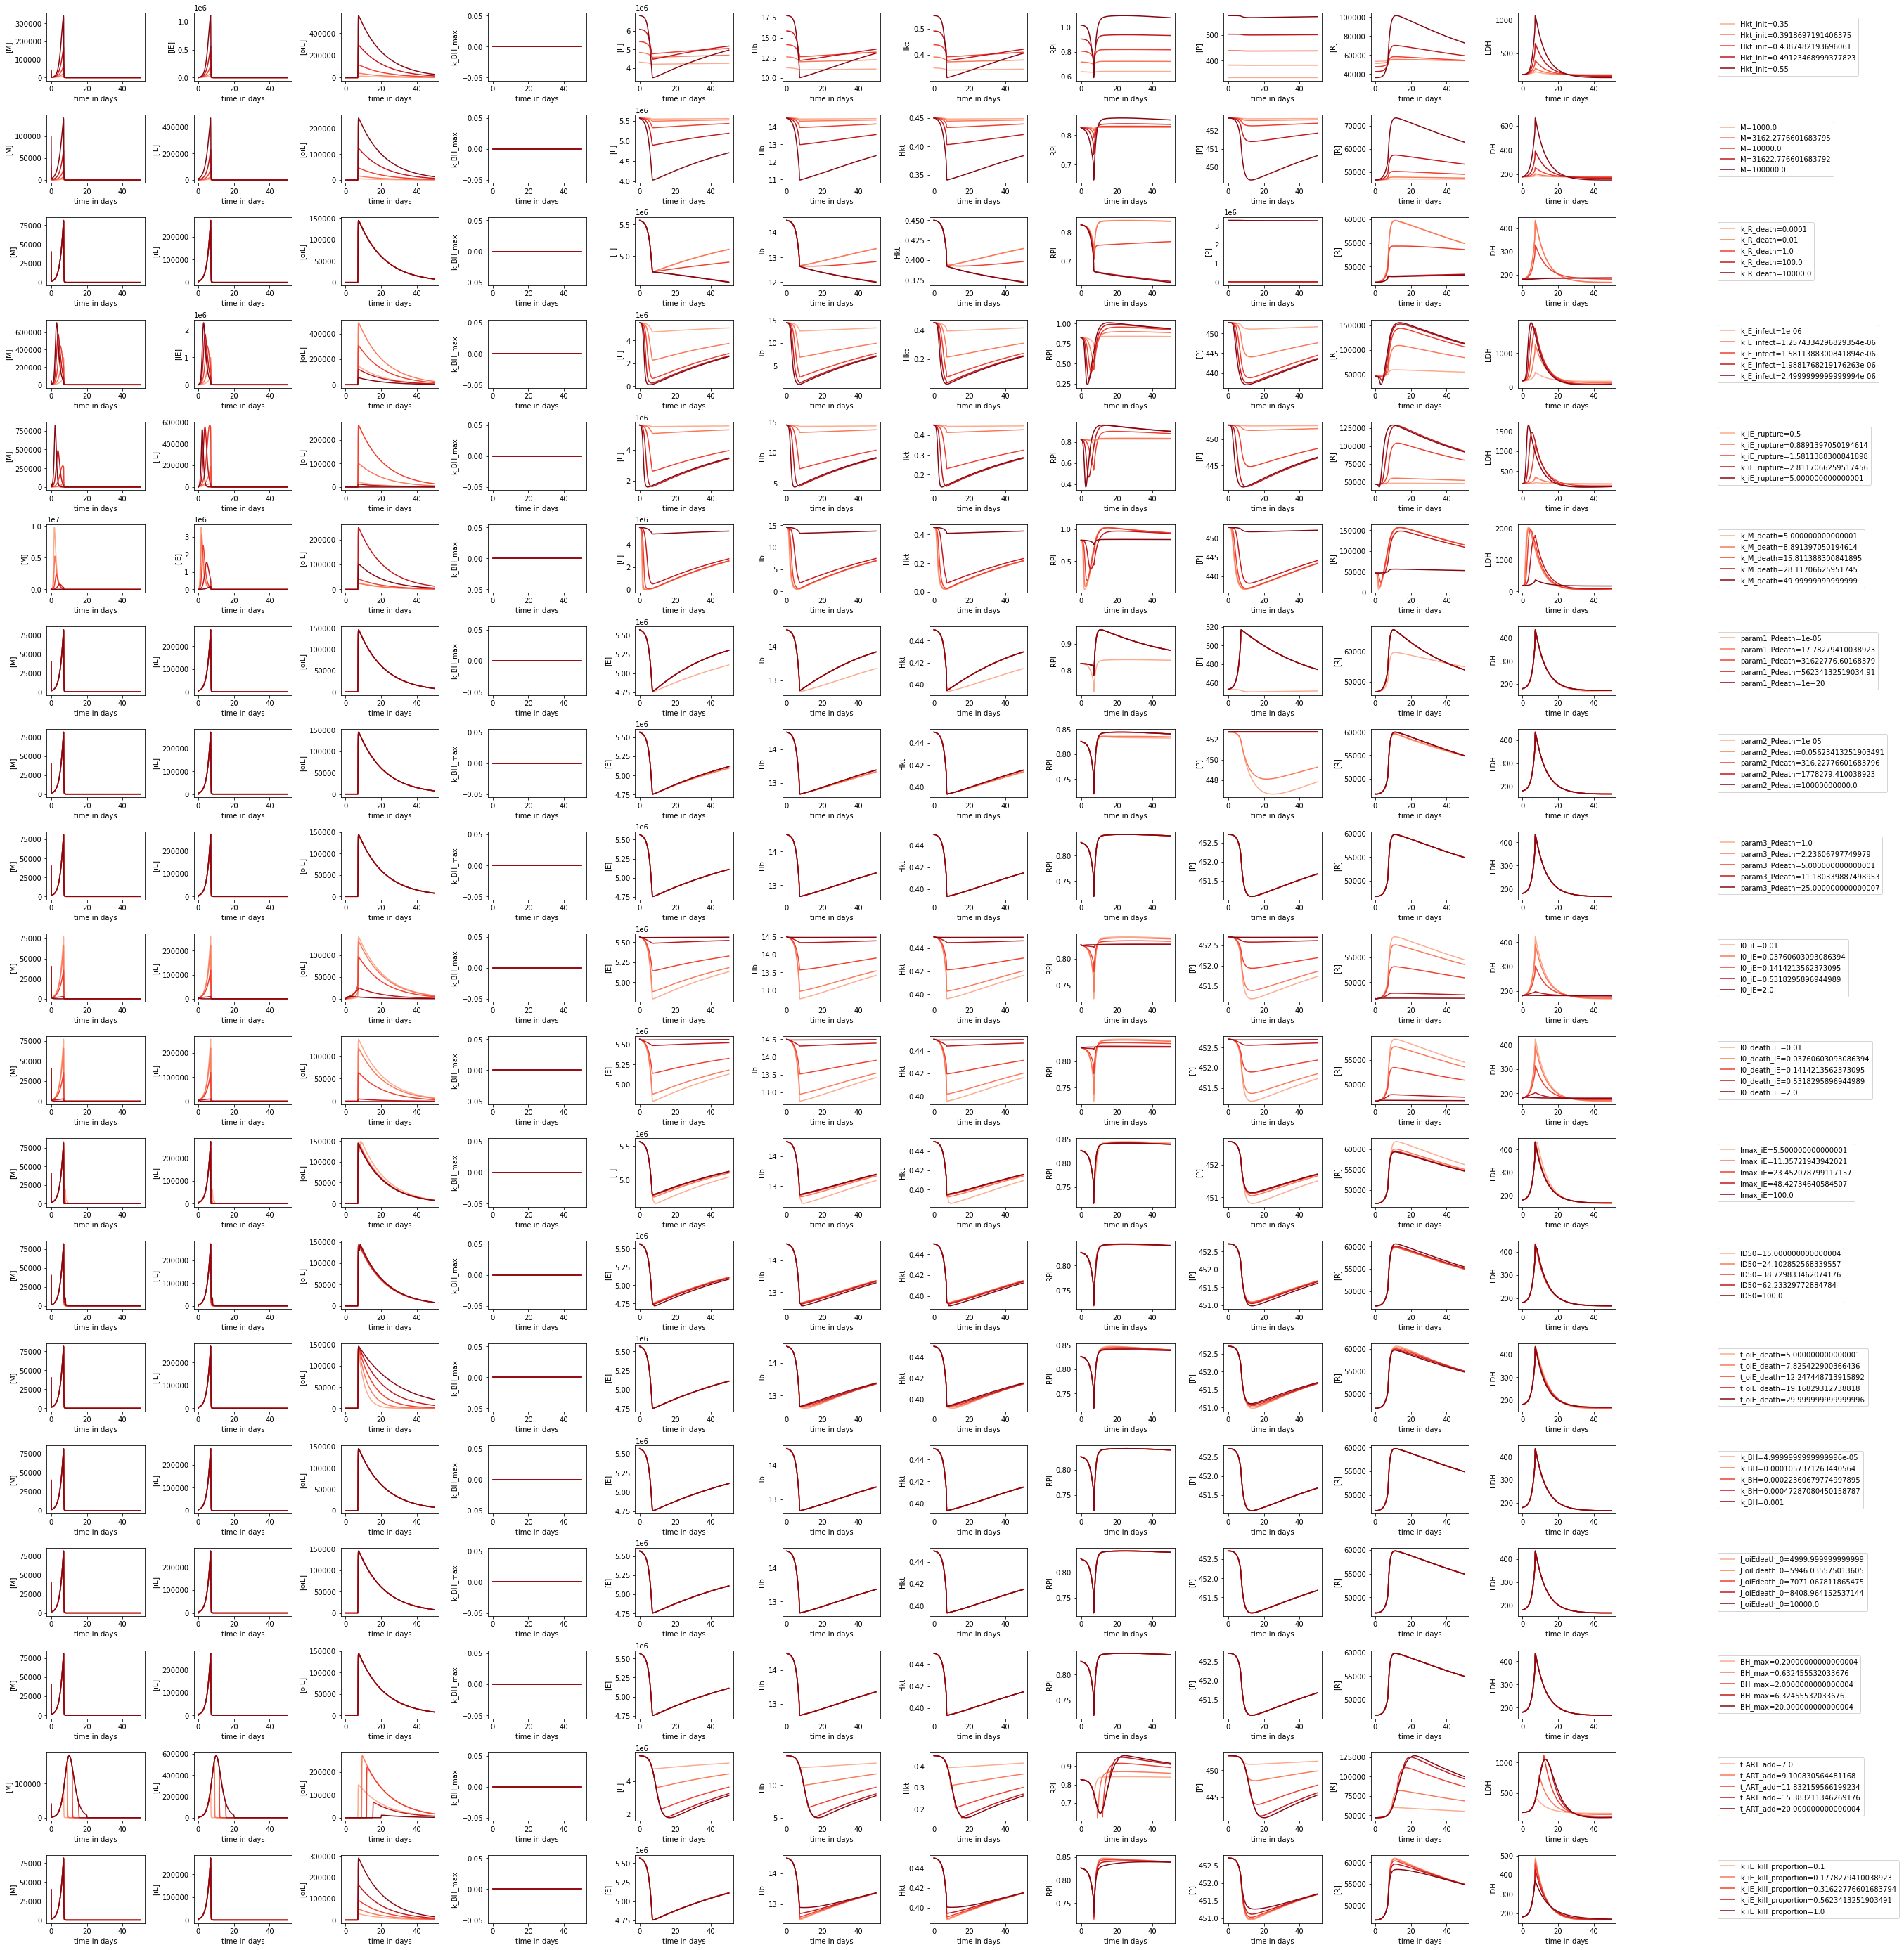

In [4]:
#Spezies
species_to_analyze = ['[M]','[iE]','[oiE]', 'k_BH_max','[E]','Hb','Hkt', 'RPI','[P]','[R]','LDH']

# Definition der Parameter-Boundaries
params_bounds = OrderedDict({
    'Hkt_init': (0.35, 0.55), 
    'M': (1e3, 1e5),                #
    'k_R_death': (1e-4, 1e4),         #rausnehmen aus fitting und auf 0 setzen im Model 
    'k_E_infect': (1e-6, 2.5e-6),   #
    'k_iE_rupture': (5e-1, 5),      #
    'k_M_death': (5, 50) ,          # höher als 3 sonst Reinfetion
    'param1_Pdeath': (1e-5, 1e20),  #sigmoid (1e-2,1e3),     # aus fitting rauslasen zu wenig einfluss    2e-5,0.01
    'param2_Pdeath': (1e-5, 1e10),  #sigmoid (1e-2,1e3) ,   #  aus fitting rauslasen zu wenig einfluss   0.01, 10
    'param3_Pdeath':  (1,25) , 
    'I0_iE': (1e-2, 2),             #
    'I0_death_iE': (1e-2, 2),       #
    'Imax_iE': (5.5, 1e2),     #5.5 war gut als unterer wenn viel niedriger Reinfektion, 1e1 oberre?
    #'hill': (2, 2.5),
    'ID50': (15, 1e2),             
    't_oiE_death': (5, 30),         #
    #'t_halb_LDH_decay': (2, 14),
    'k_BH': (5e-5, 1e-3),  #
    'J_oiEdeath_0': (5e3, 1e4),    #
    'BH_max': (2e-1, 20),
    't_ART_add': (7, 20),           #  
    'k_iE_kill_proportion': (0.1 ,1),
})


# Konvertiere bounds in logscale
params_bounds_log = pf.convert_bounds_to_logscale(params_bounds)

# Anzahl der Werte pro Parameter 
num_values_per_param = 5

# Erzeugung der Wertemengen für jeden Parameter
param_values = {}
for param, bounds in params_bounds_log.items():
    param_values[param] = np.linspace(bounds[0], bounds[1], num_values_per_param)

# Durchführung des Parameter-Scans und Erstellung der Plots
fig, axs = plt.subplots(len(params_bounds),len(species_to_analyze), figsize=(40, 50))
fig.subplots_adjust(hspace=0.5, wspace= 0.5)

# Farbübergang
cmap = plt.colormaps.get_cmap('Reds')
color_start = 0.3


for i, (param, values) in enumerate(param_values.items()):

    for idx, value in enumerate(values):
        model = te.loada('.././model/OIE_model.ant')
        #model.resetToOrigin()
        #model.setValue(param, 10**value)

        #"""
        model_str = model.getAntimony()        #lade Antimony string
        model_lines = model_str.split('\n')    #splitte in für jede Zeile
        new_model_lines = []

        for line in model_lines:         #gehe alle zeielen durch, ändere wnn parameter geändert werden soll, füge in neuen strig zu
            if line.startswith(f'{param}=') or line.startswith(f'{param} '):   # if line.startswith(param):
                line = f'{param}={10**value}'
            if line.startswith(f'BH_max=') or line.startswith(f'BH_max '):   # if line.startswith(param):
                line = f'BH_max=0'
            new_model_lines.append(line)
        new_model_str = '\n'.join(new_model_lines)    
        model = te.loada(new_model_str) 
        #"""

        result = model.simulate(0, 50, 500, ['time']+species_to_analyze)
        
        for j, specie in enumerate (species_to_analyze):

            # Plot der Ergebnisse
            axs[i][j].plot(result['time'], result[specie], label=f'{param}={10**value}', color=cmap(color_start + idx * (00.8 / num_values_per_param)))
            axs[i][j].set_xlabel('time in days')
            axs[i][j].set_ylabel(specie)
            if j == (len(species_to_analyze)-1):
                handles, labels = axs[i][j].get_legend_handles_labels()  # Legend Box outsides Subplots
                axs[i][j].legend(handles, labels, loc='center left', bbox_to_anchor=(2, 0.5),) #bbox (nach rechts-links, oben-unten, negativ yes)
plt.show()

#plt.savefig("plot.pdf")